https://arxiv.org/pdf/1512.00567.pdf

Inception V2とV3は同じ論文で紹介されており、GoogleNet(Inception V1)の改良となっています。 
factorizationにより、ある畳み込み層をそれより小さいkernel sizeの畳み込みに分解することで計算コストを削減しています。
また、V3はV2を少し修正したものであり実装はほとんど変わりません。  
ここではV3の実装を行います。  
  
自分では論文を読み解けない部分もあり、多くの部分を以下のサイトを参考にしています。  

https://pystyle.info/pytorch-inceptionv3/

https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v3.py

### Inception V3

#### Inception Modules
Inception V3では複数の種類のInception Moduleがでてきます。  
まず、Inception V3の構造を見ます。

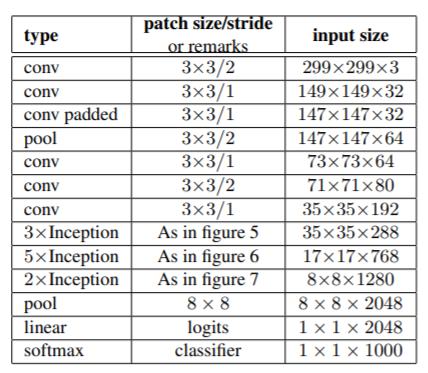

表内の3種類のInception以外にそれぞれのInception間にチャンネル数と画像サイズを変えるためのInceptionが挿入されます。
従って全部で5種類のInceptionが出てきますが論文内では特に名前が付いていないので
- Inceptionx3
- Inceptionx5
- Inceptionx2
- Inception3to5
- Inception5to2

とします。
さらに、5xInceptionの後には、GoogleNet(Inception V1)同様にAuxiliary Classifierが挿入され、この出力も使って学習を行います。ただし、V1では2つありましたが今回は1つです。

#### Inceptionx3

下の図の通り5×5の畳み込み層を2つの3×3の畳み込み層に分解することができて、これにより計算コストを下げることができます。  
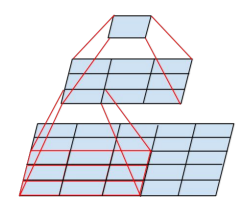

次の上の図はGoogleNetのInception Moduleですが、今回はこの5×5の畳み込み層を下図のように2つの3×3の畳み込み層に分解します。

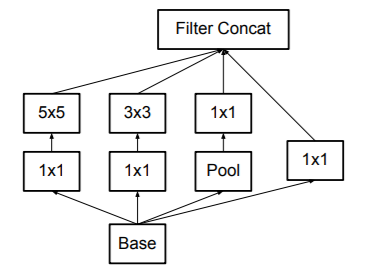
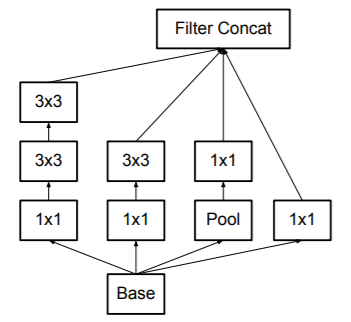

#### Inceptionx5

さらに、計算コストを下げるため$n×n$の畳み込み層を$1×n$と$n×1$の2つの畳み込み層に分解します。
$3×3$の畳み込み層の場合の例を図に示します。  
$1×3$と$3×1$の2つの畳み込み層の出力は$3×3$の畳み込み層と同じになることが分かります。

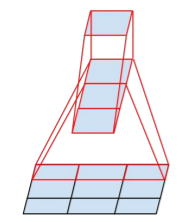

これを利用するとInception Moduleは次の図のようになります。

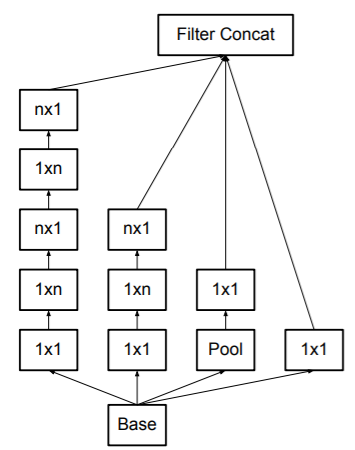

この構造のInception Moduleは画像サイズが17×17のものに使用し、そのときは$n=7$とします。 


#### Inceptionx2

さらに、直列に分解するのではなく下図のように並列に分解したInception Moduleも使用します。


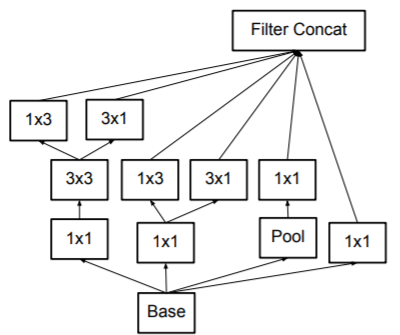


#### Inception3to5(Inception5to2)

Inception Module間では画像サイズが半減し、チャンネル数が増加します。  
この処理は以下のような、畳み込みとプーリングを並列に処理する構造のInception Moduleを使用します。

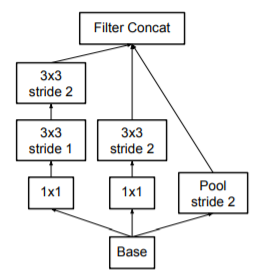

ただし、図の構造はInceptionx3とInceptionx5の間で使用し、Inceptionx5とInceptionx2の間では別の構造のInception Moculeを使用します。  
Inception5to2の場合は、3×3の畳み込みが2つ並んでいる部分の1つ目の畳み込みが7×1と1×7の畳み込みの2つの層に置き換えたものを使用します。

#### Auxiliary Classifier

論文では以下のように紹介されていますが、今回は参考サイトをもとに図のプーリングと畳み込みの間にもう一つ畳み込み層を入れて使用します。


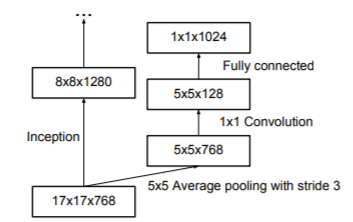


#### Label Smoothing
学習の際にLabel Smoothingと呼ばれる正則化を行います。  
正解ラベルを以下のように変形したものに変更します。

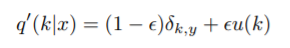


ここで$K$はクラス数、$\epsilon$は足し合わせる割合です。  
$\delta$は正解ラベルをワンホットエンコーディングしたものです。

#### 学習
バッチサイズ32で100エポックで学習を行います。  
RMSPropを使用し、decayは0.9、$\epsilon$は1.0です。  
学習率は0.045で、2エポックごとにrateを0.94として指数的に減衰させていきます。  
勾配を2でクリッピングすると学習を安定させることができることもわかりました。

In [100]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import math
import cv2

In [69]:
class conv_bn_relu(Model):
    def __init__(self, out_channels, kernel_size=1, strides=1, padding='same'):
        super(conv_bn_relu, self).__init__()
        self.conv = Conv2D(out_channels, kernel_size=kernel_size, strides=strides, padding=padding)
        self.bn = BatchNormalization()
        self.relu = Activation("relu")

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [70]:
class Inceptionx3(Model):
    def __init__(self):
        super(Inceptionx3, self).__init__()
        self.brabch1 = conv_bn_relu(out_channels=64, kernel_size=1, strides=1)
        self.branch2 = Sequential([conv_bn_relu(out_channels=48, kernel_size=1, strides=1),
                                   conv_bn_relu(out_channels=64, kernel_size=3, strides=1)])
        self.branch3 = Sequential([conv_bn_relu(out_channels=64, kernel_size=1, strides=1),
                                   conv_bn_relu(out_channels=96, kernel_size=3, strides=1),
                                   conv_bn_relu(out_channels=96, kernel_size=3, strides=1)])
        self.branch4 = Sequential([MaxPooling2D(pool_size=3, strides=1, padding='same'),
                                   conv_bn_relu(out_channels=64, kernel_size=1, strides=1)])

    def call(self, x):
        brabch1 = self.brabch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        brabch4 = self.branch4(x)
        
        out = concatenate([brabch1, brabch2, brabch3, brabch4], axis = -1)
        return out

In [71]:
class Inceptionx5(Model):
    def __init__(self):
        super(Inceptionx5, self).__init__()
        self.brabch1 = conv_bn_relu(out_channels=192, kernel_size=1, strides=1)
        self.branch2 = Sequential([conv_bn_relu(out_channels=128, kernel_size=1, strides=1),
                                   conv_bn_relu(out_channels=128, kernel_size=(1,7), strides=1),
                                   conv_bn_relu(out_channels=192, kernel_size=(7,1), strides=1)])
        self.branch3 = Sequential([conv_bn_relu(out_channels=128, kernel_size=1, strides=1),
                                   conv_bn_relu(out_channels=128, kernel_size=(1,7), strides=1),
                                   conv_bn_relu(out_channels=128, kernel_size=(7,1), strides=1),
                                   conv_bn_relu(out_channels=128, kernel_size=(1,7), strides=1),
                                   conv_bn_relu(out_channels=192, kernel_size=(7,1), strides=1)])
        self.branch4 = Sequential([MaxPooling2D(pool_size=3, strides=1, padding='same'),
                                   conv_bn_relu(out_channels=192, kernel_size=1, strides=1)])

    def call(self, x):
        brabch1 = self.brabch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        brabch4 = self.branch4(x)
        
        out = concatenate([brabch1, brabch2, brabch3, brabch4], axis = -1)
        return out

In [72]:
class Inceptionx2(Model):
    def __init__(self):
        super(Inceptionx2, self).__init__()
        self.brabch1 = conv_bn_relu(out_channels=320, kernel_size=1, strides=1)
        self.branch2 = Sequential([conv_bn_relu(out_channels=384, kernel_size=1, strides=1)])
        self.brabch2_1 = Sequential([conv_bn_relu(out_channels=384, kernel_size=(1,3), strides=1)])
        self.brabch2_2 = Sequential([conv_bn_relu(out_channels=384, kernel_size=(3,1), strides=1)])
        self.branch3 = Sequential([conv_bn_relu(out_channels=448, kernel_size=1, strides=1),
                                   conv_bn_relu(out_channels=384, kernel_size=3, strides=1)])
        self.brabch3_1 = Sequential([conv_bn_relu(out_channels=384, kernel_size=(1,3), strides=1)])
        self.brabch3_2 = Sequential([conv_bn_relu(out_channels=384, kernel_size=(3,1), strides=1)])
        self.branch4 = Sequential([MaxPooling2D(pool_size=3, strides=1, padding='same'),
                                   conv_bn_relu(out_channels=192, kernel_size=1, strides=1)])

    def call(self, x):
        brabch1 = self.brabch1(x)
        
        brabch2 = self.branch2(x)
        brabch2_1 = self.brabch2_1(brabch2)
        brabch2_2 = self.brabch2_2(brabch2)
        
        brabch3 = self.branch3(x)
        brabch3_1 = self.brabch3_1(brabch3)
        brabch3_2 = self.brabch3_2(brabch3)
        
        brabch4 = self.branch4(x)
        
        out = concatenate([brabch1, brabch2_1, brabch2_2, brabch3_1, brabch3_2, brabch4], axis = -1)
        return out

In [73]:
class Inception3to5(Model):
    def __init__(self):
        super(Inception3to5, self).__init__()
        self.branch1 = Sequential([conv_bn_relu(out_channels=64, kernel_size=1, strides=1, padding='same'),
                                   conv_bn_relu(out_channels=96, kernel_size=3, strides=1, padding='same'),
                                   conv_bn_relu(out_channels=96, kernel_size=3, strides=2, padding='valid')])
        self.branch2 = Sequential([conv_bn_relu(out_channels=384, kernel_size=1, strides=1, padding='same'),
                                   conv_bn_relu(out_channels=384, kernel_size=3, strides=2, padding='valid')])
        self.branch3 = Sequential([MaxPooling2D(pool_size=3, strides=2)])

    def call(self, x):
        brabch1 = self.branch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        
        out = concatenate([brabch1, brabch2, brabch3], axis = -1)
        return out

In [74]:
class Inception5to2(Model):
    def __init__(self):
        super(Inception5to2, self).__init__()
        self.branch1 = Sequential([conv_bn_relu(out_channels=192, kernel_size=1, strides=1, padding='same'),
                                   conv_bn_relu(out_channels=320, kernel_size=3, strides=2, padding='valid')])
        self.branch2 = Sequential([conv_bn_relu(out_channels=192, kernel_size=1, strides=1, padding='same'),
                                   conv_bn_relu(out_channels=192, kernel_size=(1, 7), strides=1, padding='same'),
                                   conv_bn_relu(out_channels=192, kernel_size=(7, 1), strides=1, padding='same'),
                                   conv_bn_relu(out_channels=192, kernel_size=3, strides=2, padding='valid')])
        self.branch3 = Sequential([MaxPooling2D(pool_size=3, strides=2)])

    def call(self, x):
        brabch1 = self.branch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        
        out = concatenate([brabch1, brabch2, brabch3], axis = -1)
        return out

In [115]:
class InceptionAux(Model):
    def __init__(self, num_classes=10):
        super(InceptionAux, self).__init__()
        self.pool1 = AveragePooling2D(pool_size=5, strides=3)
        self.conv0 = conv_bn_relu(128, kernel_size=1)
        self.conv1 = conv_bn_relu(768, kernel_size=5)
        self.pool2 = GlobalAveragePooling2D()
        self.fc = Dense(num_classes, activation = 'softmax')

    def call(self, x):
        x = self.pool1(x)
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.pool2(x)
        x = self.fc(x)

        return x

In [116]:
class InceptionV3(Model):
    def __init__(self, aux=True):
        super(InceptionV3, self).__init__()
        self.conv1 = conv_bn_relu(out_channels=32, kernel_size=3, strides=2, padding='valid')
        self.conv2 = conv_bn_relu(out_channels=32, kernel_size=3, strides=1, padding='valid')
        self.conv3 = conv_bn_relu(out_channels=64, kernel_size=3, strides=1, padding='same')
        self.pool1 = MaxPooling2D(pool_size=3, strides=2)
        self.conv4 = conv_bn_relu(out_channels=80, kernel_size=3, strides=1, padding='valid')
        self.conv5 = conv_bn_relu(out_channels=192, kernel_size=3, strides=2, padding='valid')
        self.conv6 = conv_bn_relu(out_channels=288, kernel_size=3, strides=1, padding='same')
        
        self.inception3 = Sequential([Inceptionx3() for _ in range(3)])
        self.inception3to5 = Inception3to5()
        self.inception5 = Sequential([Inceptionx5() for _ in range(4)])
        self.inception5to2 = Inception5to2()
        self.inception2 = Sequential([Inceptionx2() for _ in range(2)])
        
        self.pool2 = GlobalAveragePooling2D()
        self.fc = Dense(10, activation = 'softmax')
        
        if aux:
            self.aux = InceptionAux(num_classes=10)
        else:
            self.aux = None
        
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.pool1(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        
        out = self.inception3(out)
        out = self.inception3to5(out)
        out = self.inception5(out)
        if self.aux:
            out1 = self.aux(out)
        out = self.inception5to2(out)
        out = self.inception2(out)
        
        out = self.pool2(out)
        out = self.fc(out)
        
        if self.aux:
            return out, out1
        else:
            return out

In [117]:
def label_smoothing_loss(y_true, y_pred, K=10, eps=0.1):
    y_true_smooth = y_true*(1-eps) + eps/K
    return keras.losses.categorical_crossentropy(y_true_smooth, y_pred)

In [118]:
model = InceptionV3()
model.build((None, 299, 299, 3))  # build with input shape.
dummy_input = Input(shape=(299, 299, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv_bn_relu_1280 (conv_bn_relu (None, 149, 149, 32) 1024        input_31[0][0]                   
__________________________________________________________________________________________________
conv_bn_relu_1281 (conv_bn_relu (None, 147, 147, 32) 9376        conv_bn_relu_1280[0][0]          
__________________________________________________________________________________________________
conv_bn_relu_1282 (conv_bn_relu (None, 147, 147, 64) 18752       conv_bn_relu_1281[0][0]          
______________________________________________________________________________________

In [121]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.0045
    drop = 0.94
    epochs_drop = 2
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(lr=0.045, rho=0.9, epsilon=1.0, decay=0.9)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=[label_smoothing_loss, label_smoothing_loss], loss_weights=[1, 0.3], optimizer=sgd, metrics=['accuracy'])

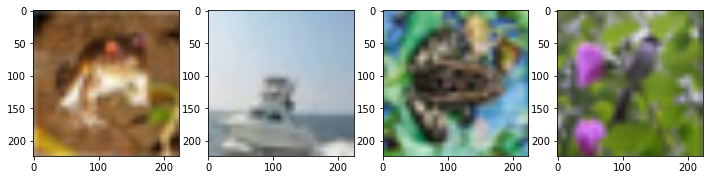

In [105]:
# データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# バッチサイズ、クラス数、エポック数の設定
batch_size=32
num_classes=10
epochs=5

# データリサイズ
img_rows=224
img_cols=224

x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train[::100,:,:,:]])
x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test[::100,:,:,:]])

# データ正規化
x_train=x_train.astype('float32')
x_train/=255
x_test=x_test.astype('float32')
x_test/=255

# one-hotベクトル化
y_train = y_train[::100]
y_test = y_test[::100]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(x_train[i]) for i in range(4)];

In [122]:
history = model.fit(x_train, [y_train, y_train], validation_data=(x_test, [y_test, y_test]), epochs=epochs, batch_size=64, callbacks=[lr_sc])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/25
Tensor("label_smoothing_loss/add:0", shape=(None, 10), dtype=float32) Tensor("IteratorGetNext:1", shape=(None, 10), dtype=float32)
Tensor("label_smoothing_loss_1/add:0", shape=(None, 10), dtype=float32) Tensor("IteratorGetNext:2", shape=(None, 10), dtype=float32)
Tensor("label_smoothing_loss/add:0", shape=(None, 10), dtype=float32) Tensor("IteratorGetNext:1", shape=(None, 10), dtype=float32)
Tensor("label_smoothing_loss_1/add:0", shape=(None, 10), dtype=float32) Tensor("IteratorGetNext:2", shape=(None, 10), dtype=float32)
5/8 [=================>............] - ETA: 1:03 - loss: 2.7094 - output_1_loss: 2.0836 - output_2_loss: 2.0861 - output_1_accuracy: 0.1781 - output_2_accuracy: 0.1562

KeyboardInterrupt: 

<function tensorflow.python.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0)>

In [123]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [126]:
class conv_bn_relu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0):
        super(conv_bn_relu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [291]:
class Inceptionx3(nn.Module):
    def __init__(self, in_channels):
        super(Inceptionx3, self).__init__()
        self.brabch1 = conv_bn_relu(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1)
        self.branch2 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=48, kernel_size=1, stride=1),
                                   conv_bn_relu(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=1)])
        self.branch3 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1),
                                   conv_bn_relu(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1),
                                   conv_bn_relu(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1)])
        self.branch4 = nn.Sequential(*[nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                   conv_bn_relu(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1)])

    def forward(self, x):
        brabch1 = self.brabch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        brabch4 = self.branch4(x)
        
        out = torch.cat([brabch1, brabch2, brabch3, brabch4], axis = 1)
        return out

In [292]:
class Inceptionx5(nn.Module):
    def __init__(self, in_channels):
        super(Inceptionx5, self).__init__()
        self.brabch1 = conv_bn_relu(in_channels=in_channels, out_channels=192, kernel_size=1, stride=1)
        self.branch2 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=128, kernel_size=1, stride=1),
                                       conv_bn_relu(in_channels=128, out_channels=128, kernel_size=(1,7), stride=1, padding=(0,3)),
                                       conv_bn_relu(in_channels=128, out_channels=192, kernel_size=(7,1), stride=1, padding=(3,0))])
        self.branch3 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=128, kernel_size=1, stride=1),
                                       conv_bn_relu(in_channels=128, out_channels=128, kernel_size=(1,7), stride=1, padding=(0,3)),
                                       conv_bn_relu(in_channels=128, out_channels=128, kernel_size=(7,1), stride=1, padding=(3,0)),
                                       conv_bn_relu(in_channels=128, out_channels=128, kernel_size=(1,7), stride=1, padding=(0,3)),
                                       conv_bn_relu(in_channels=128, out_channels=192, kernel_size=(7,1), stride=1, padding=(3,0))])
        self.branch4 = nn.Sequential(*[nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                       conv_bn_relu(in_channels=in_channels, out_channels=192, kernel_size=1, stride=1)])

    def forward(self, x):
        brabch1 = self.brabch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        brabch4 = self.branch4(x)
        
        out = torch.cat([brabch1, brabch2, brabch3, brabch4], axis = 1)
        return out

In [293]:
class Inceptionx2(nn.Module):
    def __init__(self, in_channels):
        super(Inceptionx2, self).__init__()
        self.brabch1 =   conv_bn_relu(in_channels=in_channels, out_channels=320, kernel_size=1, stride=1)
        self.branch2 =   nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=384, kernel_size=1, stride=1)])
        self.brabch2_1 = nn.Sequential(*[conv_bn_relu(in_channels=384, out_channels=384, kernel_size=(1,3), stride=1, padding=(0,1))])
        self.brabch2_2 = nn.Sequential(*[conv_bn_relu(in_channels=384, out_channels=384, kernel_size=(3,1), stride=1, padding=(1,0))])
        self.branch3 =   nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=448, kernel_size=1, stride=1),
                                         conv_bn_relu(in_channels=448, out_channels=384, kernel_size=3, stride=1, padding=1)])
        self.brabch3_1 = nn.Sequential(*[conv_bn_relu(in_channels=384, out_channels=384, kernel_size=(1,3), stride=1, padding=(0,1))])
        self.brabch3_2 = nn.Sequential(*[conv_bn_relu(in_channels=384, out_channels=384, kernel_size=(3,1), stride=1, padding=(1,0))])
        self.branch4 =   nn.Sequential(*[nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                         conv_bn_relu(in_channels=in_channels, out_channels=192, kernel_size=1, stride=1)])

    def forward(self, x):
        brabch1 = self.brabch1(x)
        
        brabch2 = self.branch2(x)
        brabch2_1 = self.brabch2_1(brabch2)
        brabch2_2 = self.brabch2_2(brabch2)
        
        brabch3 = self.branch3(x)
        brabch3_1 = self.brabch3_1(brabch3)
        brabch3_2 = self.brabch3_2(brabch3)
        
        brabch4 = self.branch4(x)
        
        out = torch.cat([brabch1, brabch2_1, brabch2_2, brabch3_1, brabch3_2, brabch4], axis = 1)
        return out

In [294]:
class Inception3to5(nn.Module):
    def __init__(self, in_channels):
        super(Inception3to5, self).__init__()
        self.branch1 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1, padding=0),
                                       conv_bn_relu(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1),
                                       conv_bn_relu(in_channels=96, out_channels=96, kernel_size=3, stride=2, padding=0)])
        self.branch2 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=384, kernel_size=1, stride=1, padding=0),
                                       conv_bn_relu(in_channels=384, out_channels=384, kernel_size=3, stride=2, padding=0)])
        self.branch3 = nn.Sequential(*[nn.MaxPool2d(kernel_size=3, stride=2)])

    def forward(self, x):
        brabch1 = self.branch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        
        out = torch.cat([brabch1, brabch2, brabch3], axis = 1)
        return out

In [295]:
class Inception5to2(nn.Module):
    def __init__(self, in_channels):
        super(Inception5to2, self).__init__()
        self.branch1 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=192, kernel_size=1, stride=1, padding=0),
                                       conv_bn_relu(in_channels=192, out_channels=320, kernel_size=3, stride=2, padding=0)])
        self.branch2 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=192, kernel_size=1, stride=1, padding=0),
                                       conv_bn_relu(in_channels=192, out_channels=192, kernel_size=(1, 7), stride=1, padding=(0,3)),
                                       conv_bn_relu(in_channels=192, out_channels=192, kernel_size=(7, 1), stride=1, padding=(3,0)),
                                       conv_bn_relu(in_channels=192, out_channels=192, kernel_size=3, stride=2, padding=0)])
        self.branch3 = nn.Sequential(*[nn.MaxPool2d(kernel_size=3, stride=2)])

    def forward(self, x):
        brabch1 = self.branch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        
        out = torch.cat([brabch1, brabch2, brabch3], axis = 1)
        return out

In [296]:
class InceptionAux(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionAux, self).__init__()
        self.pool1 = nn.AvgPool2d(kernel_size=5, stride=3, padding=0)
        self.conv0 = conv_bn_relu(in_channels=768, out_channels=128, kernel_size=1, stride=1,padding=0)
        self.conv1 = conv_bn_relu(in_channels=128, out_channels=768, kernel_size=5, stride=1,padding=2)
        self.fc = nn.Linear(768*5*5, num_classes)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv0(x)
        x = self.conv1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x

In [297]:
class InceptionV3(nn.Module):
    def __init__(self):
        super(InceptionV3, self).__init__()
        self.conv1 = conv_bn_relu(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.conv2 = conv_bn_relu(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv3 = conv_bn_relu(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv4 = conv_bn_relu(in_channels=64, out_channels=80, kernel_size=3, stride=1, padding=0)
        self.conv5 = conv_bn_relu(in_channels=80, out_channels=192, kernel_size=3, stride=2, padding=0)
        self.conv6 = conv_bn_relu(in_channels=192, out_channels=288, kernel_size=3, stride=1, padding=1)
        
        self.inception3 = nn.Sequential(*[Inceptionx3(in_channels=288) for _ in range(3)])
        self.inception3to5 = Inception3to5(in_channels=288)
        self.inception5 = nn.Sequential(*[Inceptionx5(in_channels=768) for _ in range(4)])
        self.inception5to2 = Inception5to2(in_channels=768)
        self.inception2 = nn.Sequential(*[Inceptionx2(in_channels=1280),
                                          Inceptionx2(in_channels=2048)])
        
        self.pool2 = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, 10)
        
        self.aux = InceptionAux(num_classes=10)
        
    def forward(self, x, training=False):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.pool1(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        
        out = self.inception3(out)
        out = self.inception3to5(out)
        out = self.inception5(out)
        if self.aux:
            out1 = self.aux(out)
        out = self.inception5to2(out)
        out = self.inception2(out)
        
        out = self.pool2(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        
        if training:
            return out, out1
        else:
            return out

In [298]:
from torchsummary import summary


summary(InceptionV3(), (3,299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             896
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
      conv_bn_relu-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,248
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
      conv_bn_relu-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,496
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
     conv_bn_relu-12         [-1, 64, 147, 147]               0
        MaxPool2d-13           [-1, 64, 73, 73]               0
           Conv2d-14           [-1, 80,

     BatchNorm2d-125           [-1, 96, 17, 17]             192
            ReLU-126           [-1, 96, 17, 17]               0
    conv_bn_relu-127           [-1, 96, 17, 17]               0
          Conv2d-128          [-1, 384, 35, 35]         110,976
     BatchNorm2d-129          [-1, 384, 35, 35]             768
            ReLU-130          [-1, 384, 35, 35]               0
    conv_bn_relu-131          [-1, 384, 35, 35]               0
          Conv2d-132          [-1, 384, 17, 17]       1,327,488
     BatchNorm2d-133          [-1, 384, 17, 17]             768
            ReLU-134          [-1, 384, 17, 17]               0
    conv_bn_relu-135          [-1, 384, 17, 17]               0
       MaxPool2d-136          [-1, 288, 17, 17]               0
   Inception3to5-137          [-1, 768, 17, 17]               0
          Conv2d-138          [-1, 192, 17, 17]         147,648
     BatchNorm2d-139          [-1, 192, 17, 17]             384
            ReLU-140          [-1, 192, 

    conv_bn_relu-253          [-1, 128, 17, 17]               0
          Conv2d-254          [-1, 192, 17, 17]         172,224
     BatchNorm2d-255          [-1, 192, 17, 17]             384
            ReLU-256          [-1, 192, 17, 17]               0
    conv_bn_relu-257          [-1, 192, 17, 17]               0
       MaxPool2d-258          [-1, 768, 17, 17]               0
          Conv2d-259          [-1, 192, 17, 17]         147,648
     BatchNorm2d-260          [-1, 192, 17, 17]             384
            ReLU-261          [-1, 192, 17, 17]               0
    conv_bn_relu-262          [-1, 192, 17, 17]               0
     Inceptionx5-263          [-1, 768, 17, 17]               0
          Conv2d-264          [-1, 192, 17, 17]         147,648
     BatchNorm2d-265          [-1, 192, 17, 17]             384
            ReLU-266          [-1, 192, 17, 17]               0
    conv_bn_relu-267          [-1, 192, 17, 17]               0
          Conv2d-268          [-1, 128, 

          Conv2d-381            [-1, 320, 8, 8]         655,680
     BatchNorm2d-382            [-1, 320, 8, 8]             640
            ReLU-383            [-1, 320, 8, 8]               0
    conv_bn_relu-384            [-1, 320, 8, 8]               0
          Conv2d-385            [-1, 384, 8, 8]         786,816
     BatchNorm2d-386            [-1, 384, 8, 8]             768
            ReLU-387            [-1, 384, 8, 8]               0
    conv_bn_relu-388            [-1, 384, 8, 8]               0
          Conv2d-389            [-1, 384, 8, 8]         442,752
     BatchNorm2d-390            [-1, 384, 8, 8]             768
            ReLU-391            [-1, 384, 8, 8]               0
    conv_bn_relu-392            [-1, 384, 8, 8]               0
          Conv2d-393            [-1, 384, 8, 8]         442,752
     BatchNorm2d-394            [-1, 384, 8, 8]             768
            ReLU-395            [-1, 384, 8, 8]               0
    conv_bn_relu-396            [-1, 384

In [304]:
class InceptionV3Trainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = InceptionV3()
        
    def forward(self, x, training=False):
        x = self.model(x, training=training)
        return x
    
    def labelsmoothing_loss(self, y_hat, y):
        eps = 0.1
        K = 10
        y_onehot = torch.empty(size=(y.size(0), K), device='cpu') \
                                  .fill_(eps /(K-1)) \
                                  .scatter_(1, y.unsqueeze(1), 1.-eps)
        y_true_smooth = y_onehot*(1-eps) + eps/K
        loss = -(y_true_smooth*F.log_softmax(y_hat, -1)).sum()/y.size(0)
        return loss
        
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat, y_aux1 = self.forward(x, training=True)
        
        loss = self.labelsmoothing_loss(y_hat, y)+0.3*self.labelsmoothing_loss(y_aux1, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat, y_aux1 = self.forward(x, training=True)
        
        loss = self.labelsmoothing_loss(y_hat, y)+0.3*self.labelsmoothing_loss(y_aux1, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x, aux=False)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.RMSprop(self.parameters(), lr=0.045, eps=1.0, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.06)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [305]:
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision import models, transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt


class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((299,299)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        self.dims = (3, 299, 299)
        self.num_classes = 10
    
    def prepare_data(self):
        CIFAR10(self.data_dir, train= True, download= True)
        CIFAR10(self.data_dir, train= False, download= True)
    
    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.cifar_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


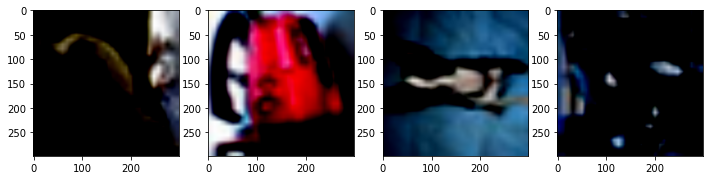

In [301]:
# Init our data pipeline
dm = CIFAR10DataModule(batch_size=32)
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(val_imgs[i].transpose(0,2)) for i in range(4)];

In [306]:
device='cpu'

net = InceptionV3Trainer().to(device)

trainer = pl.Trainer(gpus=0, max_epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [307]:
trainer.fit(net, dm)


  | Name  | Type        | Params
--------------------------------------
0 | model | InceptionV3 | 23.8 M
--------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.256    Total estimated model params size (MB)


valid Loss: 2.9920 valid Acc: 0.1719


Exception ignored in: <generator object BaseProfiler.profile_iterable at 0x000001957F2614A0>
Traceback (most recent call last):
  File "C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\pytorch_lightning\profiler\profilers.py", line 85, in profile_iterable
    except StopIteration:
KeyboardInterrupt: 


1